# Smart Application A.Y. 2024/2025 - My Update
 **Author: Francesco Paolo Liuzzi**

## Introduction
In the following notebook, I will try to demonstrate that LEMON is better than LIME in terms of faithfulness and computation time. To do this, I'll try to replicate the experiment run in the original paper by first performing some tests on a synthetic dataset and then on some random samples (data, model, parameters) obtained directly from the current working implementation of Smart Factory. All the details are in the My Update report attached to this notebook.

In [1]:
import numpy as np
import xgboost as xgb
import random
from datetime import datetime, timedelta
from XAI_forecasting import ForecastExplainer
from types import LambdaType
import pickle
import matplotlib.pyplot as plt
import os
import time

# define the random seeds
np.random.seed(42)
random.seed(42)

## Syntehtic Data Experiment

The following method replicates how currently data are processed, models are trained and predictions with explanations are made. I made some changes into the backend by implementing LEMON near the LIME implementation and made possible to return faithfulness scores of both methods in order to compare them.

In [3]:
def do_experiments(data, total_points, seq_length, kernel_width):
    # Prepare training data for XGBoost: predict next value from last seq_length values
    X_train = []
    y_train = []
    for i in range(total_points - seq_length - 1):
        X_train.append(data[i:i + seq_length])
        y_train.append(data[i + seq_length])

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    if isinstance(kernel_width, LambdaType):
        kernel_width = kernel_width(X_train.shape[1])

    # Train XGBoost model
    model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42)
    model.fit(X_train, y_train)

    # Perform predictions beyond the training range
    n_predictions = 20
    input_data = data[(total_points - seq_length - n_predictions): (total_points - n_predictions)]

    # Generate labels for the input_data
    start_date = datetime(2020, 1, 1)
    input_labels = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(seq_length)]

    # Bootstrap mode
    explainer_bootstrap = ForecastExplainer(model, X_train, y_train, use_residuals=False)
    results_bootstrap = explainer_bootstrap.predict_and_explain(
        input_data=input_data,
        n_predictions=n_predictions,
        input_labels=input_labels,
        num_features=5,
        confidence=0.95,
        n_samples=100,
        use_mean_pred=False,
        kernel_width=kernel_width
    )

    # Residual mode
    explainer_residual = ForecastExplainer(model, X_train, y_train, use_residuals=True)
    results_residual = explainer_residual.predict_and_explain(
        input_data=input_data,
        n_predictions=n_predictions,
        input_labels=input_labels,
        num_features=5,
        confidence=0.95,
        n_samples=100,
        use_mean_pred=False,
        kernel_width=kernel_width
    )
    return results_bootstrap, results_residual

Here I replicate the way LIME implementation was tested during the implementation of Smart Factory. The same test is performed on LEMON implementation. To demonstrate that LEMON faithfulness doesn't degrade as the number of data point increases, I generate a synthetic dataset of 300 samples by increasing the number of data points from 2 to 99. For each increasing step, I train a XGBoost model and generate explanations using both the bootstrap and residual method with LIME and LEMON.

In [ ]:
# Generate a sine wave
total_points = 300 
seq_length = np.arange(2, 100, 1)

t = np.linspace(0, 10 * np.pi, total_points)
data = np.sin(t) + np.random.normal(0, 0.05, size=total_points)

kernel_width = lambda n: np.sqrt(n) * .75 # to stay aligned with LIME's default kernel width, note less than can cause ill conditioning!

results = {
    'bootstrap': {
        'lime_scores': [],
        'lemon_scores': []
    },
    'residual': {
        'lime_scores': [],
        'lemon_scores': []
    }
}

# WARNING: time consuming, since a model is trained for each sequence length!!!
for sl in seq_length:
    results_bootstrap = do_experiments(data, total_points, sl, kernel_width)[0]
    results_residual = do_experiments(data, total_points, sl, kernel_width)[1]

    results['bootstrap']['lime_scores'].append(np.mean(results_bootstrap['lime_scores']))
    results['bootstrap']['lemon_scores'].append(np.mean(results_bootstrap['lemon_scores']))
    results['residual']['lime_scores'].append(np.mean(results_residual['lime_scores']))
    results['residual']['lemon_scores'].append(np.mean(results_residual['lemon_scores']))


Save the results.

In [4]:
# save results
with open('results/syn_results.pkl', 'wb') as f:
    pickle.dump(results, f)

Now I plot the results to see which one performs better.

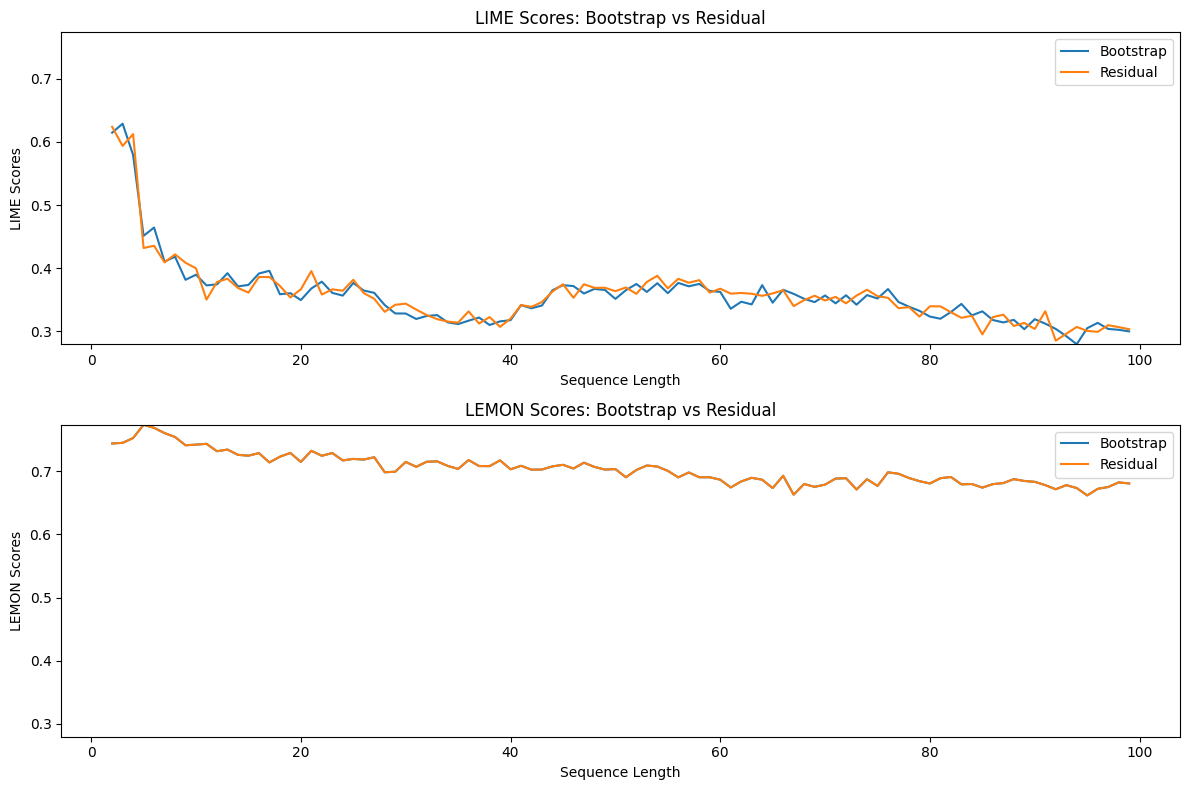

In [11]:
# Load results from pickle file
with open('results/syn_results.pkl', 'rb') as f:
    results = pickle.load(f)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot LIME scores
ax1.plot(seq_length, results['bootstrap']['lime_scores'], label='Bootstrap')
ax1.plot(seq_length, results['residual']['lime_scores'], label='Residual')
ax1.set_xlabel('Sequence Length')
ax1.set_ylabel('LIME Scores')
ax1.set_title('LIME Scores: Bootstrap vs Residual')
ax1.legend()

# Plot LEMON scores
ax2.plot(seq_length, results['bootstrap']['lemon_scores'], label='Bootstrap')
ax2.plot(seq_length, results['residual']['lemon_scores'], label='Residual')
ax2.set_xlabel('Sequence Length')
ax2.set_ylabel('LEMON Scores')
ax2.set_title('LEMON Scores: Bootstrap vs Residual')
ax2.legend()

# Set same y-axis limits for both plots
ymin = min(min(results['bootstrap']['lime_scores']), min(results['residual']['lime_scores']),
           min(results['bootstrap']['lemon_scores']), min(results['residual']['lemon_scores']))
ymax = max(max(results['bootstrap']['lime_scores']), max(results['residual']['lime_scores']),
           max(results['bootstrap']['lemon_scores']), max(results['residual']['lemon_scores']))

ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

As expected, LEMON is better than LIME. LEMON starts from an higher faithfulness score and it doesn't degrade as the number of data points increases. LIME instead starts from a lower faithfulness score and it degrades as the number of data points increases.

Since LEMON doesn't show relevant variations in faithfulness with respect to the use of bootstrap or residual method, I will check which one is better for LIME and I will use it in the next steps.

In [12]:
# Calculate average LIME scores for both approaches
avg_bootstrap_lime = np.mean(results['bootstrap']['lime_scores'])
avg_residual_lime = np.mean(results['residual']['lime_scores'])

print(f"Average LIME score for bootstrap: {avg_bootstrap_lime:.4f}")
print(f"Average LIME score for residual: {avg_residual_lime:.4f}")
print(f"\nThe {'bootstrap' if avg_bootstrap_lime > avg_residual_lime else 'residual'} approach performs better on average for LIME scores")

Average LIME score for bootstrap: 0.3573
Average LIME score for residual: 0.3584

The residual approach performs better on average for LIME scores


## Real Data


Here I replicate the same experiment on real data, using only the residual method for both LIME and LEMON. Since it's not possible to test all the possible combinations of KPIs, timeframes and machine types due to time constraints, I randomly select 10 samples and I run the experiment on them. I will then compare the faithfulness scores of LEMON and LIME.

In [2]:
def do_experiments_real_data(data, last_date, model, total_points, seq_length = 10, n_predictions = 30, kernel_width=lambda n: np.sqrt(n) * .75):
  """
  Explains predictions using XGBoost and interpretable machine learning techniques.

  :param data: Time-series data as a NumPy array or list.
  :param last_date: the starting date from which perform the predictions 
  :param model: Trained XGBoost model.
  :param total_points: Total number of data points in the series.
  :param seq_length: Length of the input sequence for prediction.
  :param n_predictions: Number of future points to predict.
  :return: None. Displays explanations and prediction results.
  """
  np.random.seed(42)

  # Prepare training data for XGBoost: predict next value from last seq_length values
  X_train = []
  y_train = []
  for i in range(total_points - seq_length - 1):
      X_train.append(data[i:i+seq_length])
      y_train.append(data[i+seq_length])

  X_train = np.array(X_train)
  y_train = np.array(y_train)

  if isinstance(kernel_width, LambdaType):
    kernel_width = kernel_width(X_train.shape[1])

  # Perform predictions beyond the training range
  input_data = data[(total_points - seq_length - n_predictions): (total_points - n_predictions)]

  # Generate labels for the input_data
  last_date = datetime.strptime(last_date, "%Y-%m-%dT%H:%M:%S.%fZ")
  start_date = last_date - timedelta(14)
  input_labels = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(seq_length)]

  # Initialize the explainer
  explainer = ForecastExplainer(model, X_train, y_train, use_residuals=True)

  # Perform predictions and explanations
  results = explainer.predict_and_explain(
      input_data=input_data,
      n_predictions=n_predictions,
      input_labels=input_labels,
      num_features=5,
      confidence=0.95,
      n_samples=100,
      use_mean_pred=True,
      kernel_width=kernel_width
  )
  return results

For each sample, let's perfom the experiment.

In [3]:
global_results = []

# for each trial, load the parameters, the model and run the experiments
for i in range(1, 11):
    pkl_filename = f'trial_data/{i}.pkl'
    json_filename = f'trial_data/{i}.json'
    
    with open(pkl_filename, 'rb') as f:
        trial_params = pickle.load(f)

    # Load model with XGBoost Booster first, then convert to XGBRegressor
    booster = xgb.Booster()
    booster.load_model(json_filename)

    # Create XGBRegressor with default parameters
    model = xgb.XGBRegressor()
    model._Booster = booster
    model._le = None

    results = do_experiments_real_data(trial_params['data'], trial_params['Last_date'], model, trial_params['total_points'], trial_params['seq_length'], trial_params['n_predictions'])
    
    mean_lime_scores = np.mean(results['lime_scores'])
    mean_lemon_scores = np.mean(results['lemon_scores'])


    # Print results
    # print(f"Trial {i}:")
    # print(f"Average LIME score: {mean_lime_scores:.4f}")
    # print(f"Average LEMON score: {mean_lemon_scores:.4f}")
    
    global_results.append([mean_lime_scores, mean_lemon_scores])

Show results.

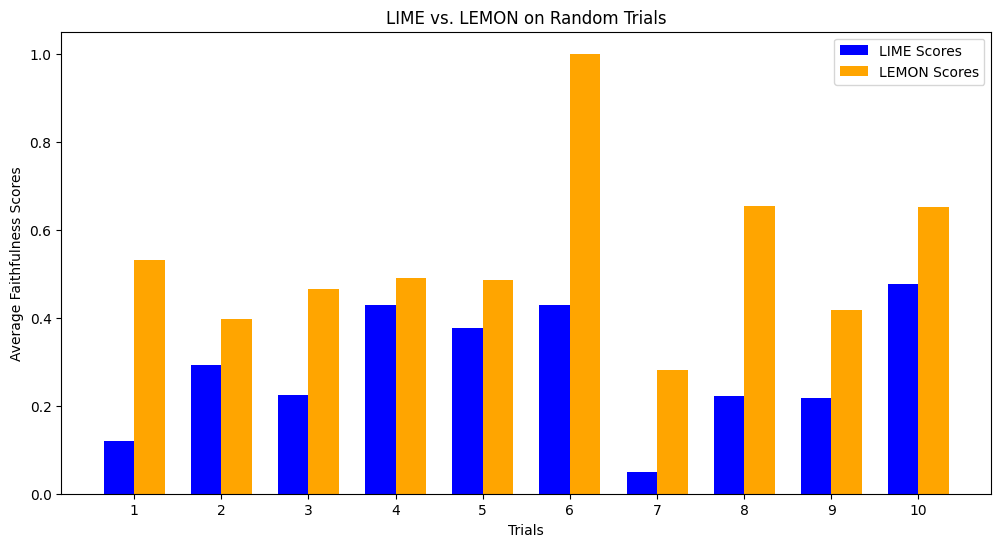

In [4]:
# Extract LIME and LEMON scores from global_results
lime_scores = [result[0] for result in global_results]
lemon_scores = [result[1] for result in global_results]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define the positions for the bars, starting from 1
positions = np.arange(1, len(global_results) + 1)

# Plot the bars
bar_width = 0.35
ax.bar(positions - bar_width/2, lime_scores, bar_width, label='LIME Scores', color='blue')
ax.bar(positions + bar_width/2, lemon_scores, bar_width, label='LEMON Scores', color='orange')

# Add labels and title
ax.set_xlabel('Trials')
ax.set_ylabel('Average Faithfulness Scores')
ax.set_title('LIME vs. LEMON on Random Trials')
ax.set_xticks(positions)
ax.legend()

# Show the plot
plt.show()

How much LEMON performed better than LIME?

In [16]:
# Calculate average scores
lime_avg = np.mean([result[0] for result in global_results])
lemon_avg = np.mean([result[1] for result in global_results])

# Calculate percentage improvement
percentage_improvement = ((lemon_avg - lime_avg) / lime_avg) * 100

print(f"LEMON performed {percentage_improvement:.2f}% better than LIME")
print(f"Average LIME score: {lime_avg:.4f}")
print(f"Average LEMON score: {lemon_avg:.4f}")

LEMON performed 89.25% better than LIME
Average LIME score: 0.2839
Average LEMON score: 0.5373


## Execution Times

I run the previous code and models on real data by disabling first LEMON explanation and then LIME explanation to check if the average execution time improves with LEMON, as a side-effect of my project improvement.

In [ ]:
lime_exec_times = []

for i in range(1, 11):
    pkl_filename = f'trial_data/{i}.pkl'
    json_filename = f'trial_data/{i}.json'
    
    with open(pkl_filename, 'rb') as f:
        trial_params = pickle.load(f)

    # Load model with XGBoost Booster first, then convert to XGBRegressor
    booster = xgb.Booster()
    booster.load_model(json_filename)

    # Create XGBRegressor with default parameters
    model = xgb.XGBRegressor()
    model._Booster = booster
    model._le = None

    # during this run, LEMON is disabled in the backend
    start_time = time.time()
    results = do_experiments_real_data(trial_params['data'], trial_params['Last_date'], model, trial_params['total_points'], trial_params['seq_length'], trial_params['n_predictions'])
    end_time = time.time()

    lime_exec_times.append(end_time - start_time)

# print the mean execution time
print(f"Average execution time for LIME: {np.mean(lime_exec_times):.4f} seconds")

# save results
with open('results/lime_exec_times.pkl', 'wb') as f:
    pickle.dump(lime_exec_times, f)

In [ ]:
lemon_exec_times = []
for i in range(1, 11):
    pkl_filename = f'trial_data/{i}.pkl'
    json_filename = f'trial_data/{i}.json'
    
    with open(pkl_filename, 'rb') as f:
        trial_params = pickle.load(f)

    # Load model with XGBoost Booster first, then convert to XGBRegressor
    booster = xgb.Booster()
    booster.load_model(json_filename)

    # Create XGBRegressor with default parameters
    model = xgb.XGBRegressor()
    model._Booster = booster
    model._le = None

    # during this run, LIME is disabled in the backend
    start_time = time.time()
    results = do_experiments_real_data(trial_params['data'], trial_params['Last_date'], model, trial_params['total_points'], trial_params['seq_length'], trial_params['n_predictions'])
    end_time = time.time()

    lemon_exec_times.append(end_time - start_time)

# print the mean execution time
print(f"Average execution time for LEMON: {np.mean(lemon_exec_times):.4f} seconds")

# save results
with open('results/lemon_exec_times.pkl', 'wb') as f:
    pickle.dump(lemon_exec_times, f)

In [17]:
# open the results files
with open('results/lime_exec_times.pkl', 'rb') as f:
    lime_exec_times = pickle.load(f)

with open('results/lemon_exec_times.pkl', 'rb') as f:
    lemon_exec_times = pickle.load(f)

print(f"Average execution time for LIME: {np.mean(lime_exec_times):.4f} seconds")
print(f"Average execution time for LEMON: {np.mean(lemon_exec_times):.4f} seconds")

# Calculate percentage improvement in execution time
lime_avg_time = np.mean(lime_exec_times)
lemon_avg_time = np.mean(lemon_exec_times)
percentage_improvement = ((lime_avg_time - lemon_avg_time) / lime_avg_time) * 100

print(f"\nLEMON is {percentage_improvement:.2f}% faster than LIME")

Average execution time for LIME: 1.9323 seconds
Average execution time for LEMON: 0.5200 seconds

LEMON is 73.09% faster than LIME


You can find all the details in the My Update report attached to this notebook.